# **SP500 Statistical Arbitrage with Gradient Boosted Regression Trees**  

# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20.

In [582]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "GBRT"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Data Collection and Pre-possessing

In [617]:
import pandas as pd
import datetime as dt
import pandas_datareader.data as web
import fix_yahoo_finance as fy
fy.pdr_override()
start = dt.datetime(2010,8,1)
end = dt.datetime(2020,8,1)

In [618]:
SP500 = web.get_data_yahoo('SPY',start,end)
SVXY = web.get_data_yahoo('SVXY',start,end)
UVXY = web.get_data_yahoo('UVXY',start,end)
VIXY = web.get_data_yahoo('VIXY',start,end)
VIXM = web.get_data_yahoo('VIXM',start,end)
TVIX = web.get_data_yahoo('TVIX',start,end)
VXX = web.get_data_yahoo('VXX',start,end)
SPXU = web.get_data_yahoo('SPXU',start,end)
SPUU = web.get_data_yahoo('SPUU',start,end)

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


# Basic portfolio---------------------

# Arbitrage Practice 1
short SP500 and short TVIX

VelocityShares Daily 2x VIX Short-Term ETN (TVIX) is already delisted. The portfolio is here just for code validation. 

In [382]:
# calculate daily returns of shorting SP500 and shorting TVIX
data1 = pd.merge(SP500.iloc[:, [4]], TVIX.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_TVIX'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] =  1 - np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]])  


In [383]:
data1.head()

,Adj Close_x,Adj Close_y,r_TVIX,r_SP500
Date,,,,
2010-11-30,97.396278,2.808750e+09,NaN,NaN
2010-12-01,99.467690,2.517250e+09,0.103783,-0.021268
2010-12-02,100.741745,2.164750e+09,0.140034,-0.012809
2010-12-03,101.013039,1.969500e+09,0.090195,-0.002693
2010-12-06,100.906151,1.892250e+09,0.039223,0.001058


In [384]:
data1 = data1.dropna()
data1

,Adj Close_x,Adj Close_y,r_TVIX,r_SP500
Date,,,,
2010-12-01,99.467690,2.517250e+09,0.103783,-0.021268
2010-12-02,100.741745,2.164750e+09,0.140034,-0.012809
2010-12-03,101.013039,1.969500e+09,0.090195,-0.002693
2010-12-06,100.906151,1.892250e+09,0.039223,0.001058
2010-12-07,100.963707,1.853250e+09,0.020610,-0.000570
...,...,...,...,...
2020-07-24,320.880005,9.600000e+01,-0.008086,0.006440
2020-07-27,323.220001,9.077000e+01,0.054479,-0.007292
2020-07-28,321.170013,8.936000e+01,0.015534,0.006342


In [385]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_TVIX,r_SP500,weekday
Date,,,,,
2020-07-24,320.880005,96.000000,-0.008086,0.006440,5
2020-07-27,323.220001,90.769997,0.054479,-0.007292,1
2020-07-28,321.170013,89.360001,0.015534,0.006342,2
2020-07-29,325.119995,86.029999,0.037265,-0.012299,3
2020-07-30,323.959991,89.599998,-0.041497,0.003568,4


In [386]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-19,308.640015,155.830002
2020-06-26,300.049988,152.669998
2020-07-10,317.589996,112.360001
2020-07-17,321.720001,112.360001
2020-07-24,320.880005,96.000000


In [387]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-27   -0.014418
2020-04-28    0.004598
2020-04-29   -0.026178
2020-04-30    0.009311
2020-05-01    0.026473
Name: r_SP500, dtype: float64

In [388]:
X = X.values.reshape((len(X),1))
X.shape

(2370, 1)

## Creation of Optimal Regressor 

In [389]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [390]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 20}

In [391]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [392]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.041652658143770414


In [393]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


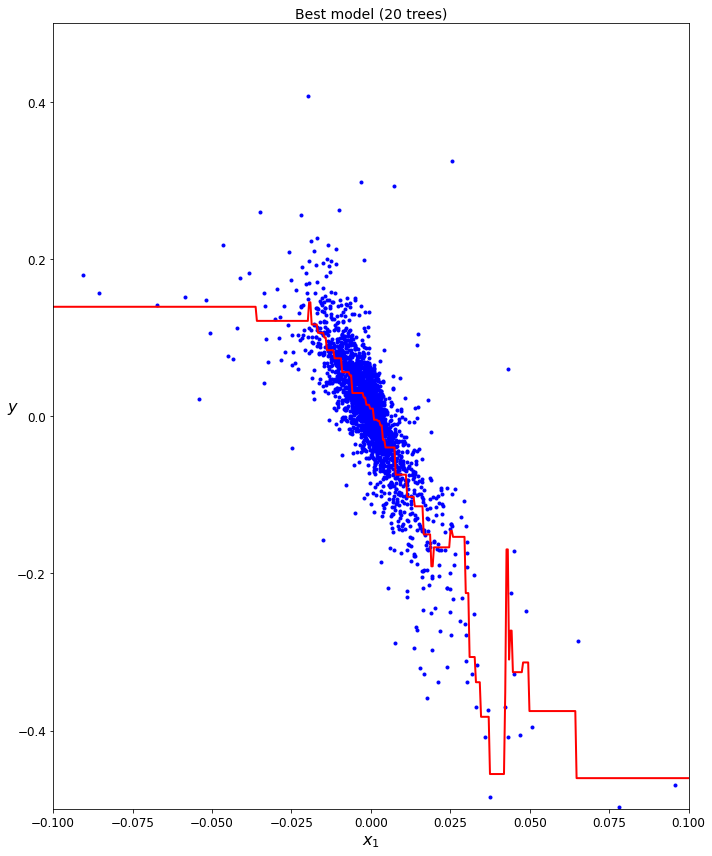

In [394]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.5, 0.5 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [395]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.04661872127473725


## Creation of Optimal Hedge Fund

In [403]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [404]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

0.001437965252441606 0.0007514980122429711 0.002124432492640241


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

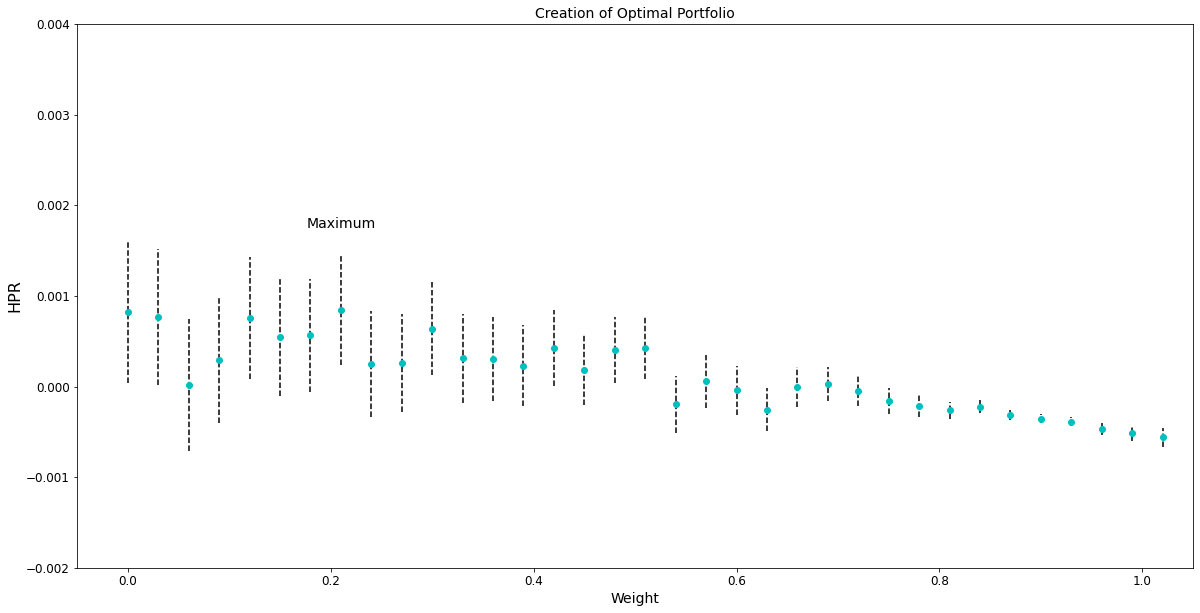

In [405]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.03,0.03)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.002, 0.004])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [400]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [401]:
print(boundary)

(-0.0181509682738926, 0.0367130043946386)


In [402]:
print(average_return)

0.009281018060372999


# Arbitrage Practice 2
long SP500 and short TVIX

VelocityShares Daily 2x VIX Short-Term ETN (TVIX) is already delisted. The portfolio is here just for code validation. 

In [445]:
# calculate daily returns of shorting SP500 and shorting TVIX
data1 = pd.merge(SP500.iloc[:, [4]], TVIX.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_TVIX'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] =  np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]]) - 1  


In [407]:
data1.head()

,Adj Close_x,Adj Close_y,r_TVIX,r_SP500
Date,,,,
2010-11-30,97.396278,2.808750e+09,NaN,NaN
2010-12-01,99.467690,2.517250e+09,0.103783,0.021268
2010-12-02,100.741745,2.164750e+09,0.140034,0.012809
2010-12-03,101.013039,1.969500e+09,0.090195,0.002693
2010-12-06,100.906151,1.892250e+09,0.039223,-0.001058


In [446]:
data1 = data1.dropna()
data1

,Adj Close_x,Adj Close_y,r_TVIX,r_SP500
Date,,,,
2010-12-01,99.467690,2.517250e+09,0.103783,0.021268
2010-12-02,100.741745,2.164750e+09,0.140034,0.012809
2010-12-03,101.013039,1.969500e+09,0.090195,0.002693
2010-12-06,100.906151,1.892250e+09,0.039223,-0.001058
2010-12-07,100.963707,1.853250e+09,0.020610,0.000570
...,...,...,...,...
2020-07-24,320.880005,9.600000e+01,-0.008086,-0.006440
2020-07-27,323.220001,9.077000e+01,0.054479,0.007292
2020-07-28,321.170013,8.936000e+01,0.015534,-0.006342


In [447]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_TVIX,r_SP500,weekday
Date,,,,,
2020-07-24,320.880005,96.000000,-0.008086,-0.006440,5
2020-07-27,323.220001,90.769997,0.054479,0.007292,1
2020-07-28,321.170013,89.360001,0.015534,-0.006342,2
2020-07-29,325.119995,86.029999,0.037265,0.012299,3
2020-07-30,323.959991,89.599998,-0.041497,-0.003568,4


In [448]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-19,308.640015,155.830002
2020-06-26,300.049988,152.669998
2020-07-10,317.589996,112.360001
2020-07-17,321.720001,112.360001
2020-07-24,320.880005,96.000000


In [449]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-27    0.014418
2020-04-28   -0.004598
2020-04-29    0.026178
2020-04-30   -0.009311
2020-05-01   -0.026473
Name: r_SP500, dtype: float64

In [450]:
X = X.values.reshape((len(X),1))
X.shape

(2370, 1)

## Creation of Optimal Regressor 

In [451]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [452]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 20}

In [453]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [454]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.041652658143770414


In [455]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


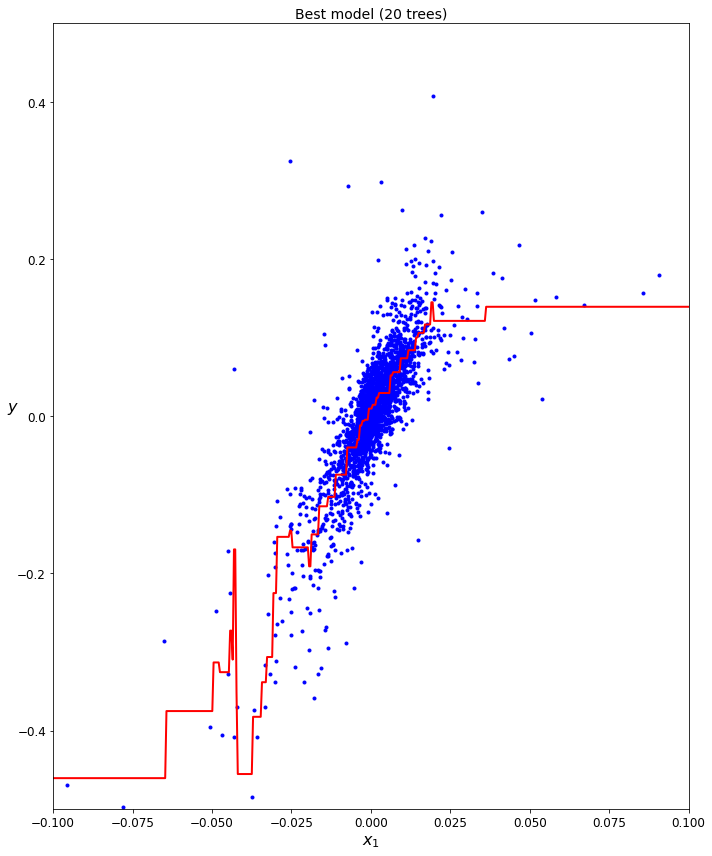

In [456]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.5, 0.5 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [457]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.04661872127473725


## Creation of Optimal Investment Portfolio

In [458]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [459]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

0.0006242253663852623 -8.248380837624241e-05 0.001330934541146767


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

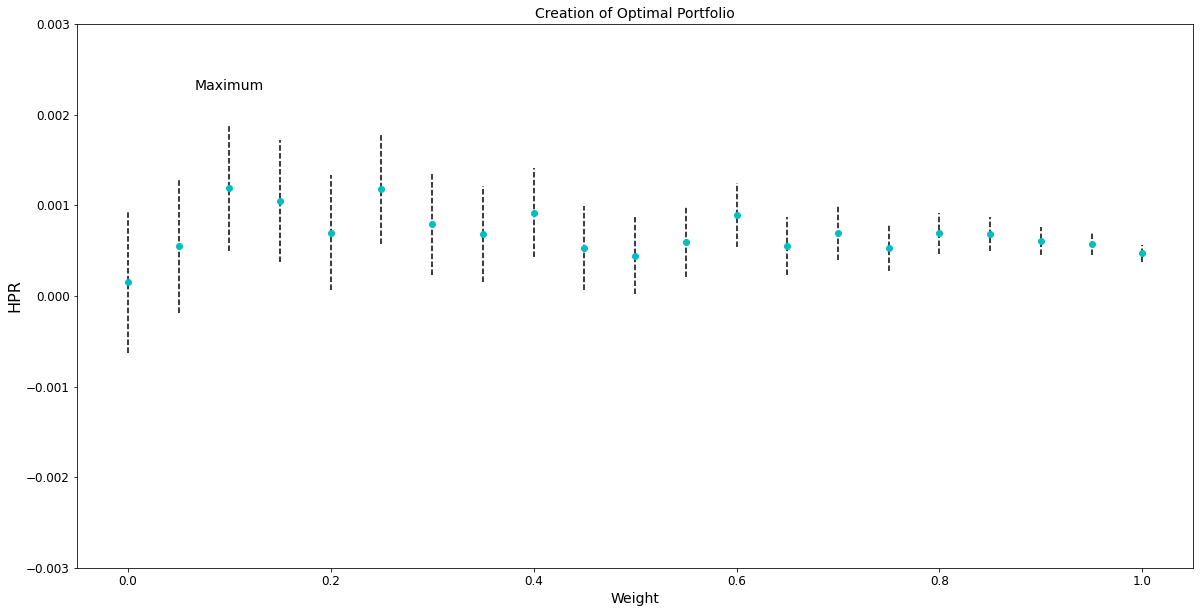

In [460]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.05,0.05)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.003, 0.003])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [461]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [462]:
print(boundary)

(-0.01744222475897998, 0.035980866851663046)


In [463]:
print(average_return)

0.009269321046341535


# Scenario 1 of Arbitrage
short SP500 and short UVXY

ProShares Ultra VIX Short-Term Futures ETF (UVXY) provides leveraged exposure to the S&P 500 VIX Short-Term Futures Index, which measures the returns of a portfolio of monthly VIX futures contracts with a weighted average of one month to expiration.

In [464]:
# calculate daily returns of shorting SP500 and shorting UVXY
data1 = pd.merge(SP500.iloc[:, [4]], UVXY.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_UVXY'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] =  1 - np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]])  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [428]:
data1.head()

,P_SP500,P_UVXY,r_UVXY,r_SP500
Date,,,,
2011-10-04,1123.949951,205800000.0,NaN,NaN
2011-10-05,1144.030029,181380000.0,0.118659,-0.017866
2011-10-06,1164.969971,174000000.0,0.040688,-0.018304
2011-10-07,1155.459961,176520000.0,-0.014483,0.008163
2011-10-10,1194.890015,155940000.0,0.116587,-0.034125


In [465]:
data1 = data1.dropna()
data1.head()

,P_SP500,P_UVXY,r_UVXY,r_SP500
Date,,,,
2011-10-05,1144.030029,181380000.0,0.118659,-0.017866
2011-10-06,1164.969971,174000000.0,0.040688,-0.018304
2011-10-07,1155.459961,176520000.0,-0.014483,0.008163
2011-10-10,1194.890015,155940000.0,0.116587,-0.034125
2011-10-11,1195.540039,150600000.0,0.034244,-0.000544


In [466]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,P_SP500,P_UVXY,r_UVXY,r_SP500,weekday
Date,,,,,
2020-07-27,3239.409912,25.969999,0.046973,-0.007395,1
2020-07-28,3218.439941,25.820000,0.005776,0.006473,2
2020-07-29,3258.439941,25.030001,0.030596,-0.012428,3
2020-07-30,3246.219971,25.889999,-0.034359,0.003750,4
2020-07-31,3271.120117,25.049999,0.032445,-0.007671,5


In [467]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,P_SP500,P_UVXY
Date,,
2020-06-26,3009.050049,38.139999
2020-07-10,3185.040039,30.230000
2020-07-17,3224.729980,27.950001
2020-07-24,3215.629883,27.250000
2020-07-31,3271.120117,25.049999


In [468]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30    0.009212
2020-05-01    0.028059
2020-05-04   -0.004250
2020-05-05   -0.009041
2020-05-06    0.006979
Name: r_SP500, dtype: float64

In [469]:
X = X.values.reshape((len(X),1))
X.shape

(2160, 1)

## Creation of Optimal Regressor 

In [470]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [471]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 22}

In [472]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=22,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [437]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.07481633213146398 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 20}
0.07457671930299596 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 21}
0.07433878102205695 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 22}
0.07412087529914732 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 23}
0.07387665928076997 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 24}
0.07366526113615171 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 25}
0.07342630468594513 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 26}
0.07321865192032194 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 27}
0.07299154167089857 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 28}
0.07276617706701818 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 29}
0.07255881765800055 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 30}
0.07234724883231894 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 31}
0.07213429368161557 {'learning_rate': 0.

In [473]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.040630390324609654


In [474]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


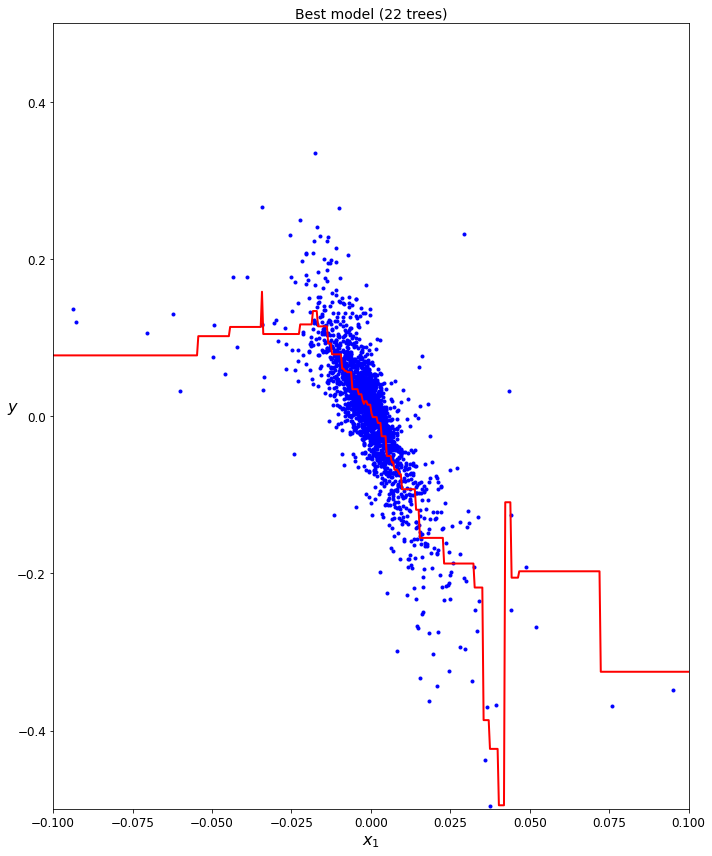

In [475]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.5, 0.5 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [476]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.04713745018535794


## Creation of Optimal Hedge Fund

In [477]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [478]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

0.0003695307338500242 -0.0003301426719664759 0.0010692041396665243


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

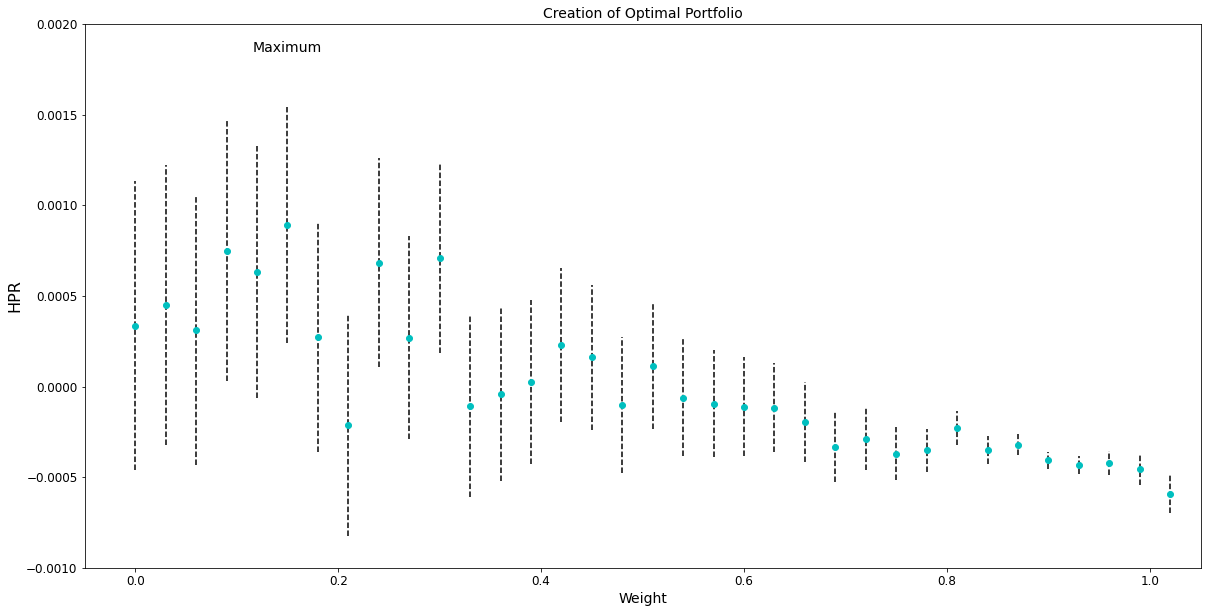

In [479]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.03,0.03)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.001, 0.002])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [480]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [481]:
print(boundary)

(-0.014759793861892205, 0.023951813854136784)


In [482]:
print(average_return)

0.004596009996122289


# Scenario 2 of Arbitrage
long SP500 and short UVXY

ProShares Ultra VIX Short-Term Futures ETF (UVXY) provides leveraged exposure to the S&P 500 VIX Short-Term Futures Index, which measures the returns of a portfolio of monthly VIX futures contracts with a weighted average of one month to expiration.

In [483]:
# calculate daily returns of longing SP500 and shorting UVXY
data1 =   pd.merge(SP500.iloc[:, [4]], UVXY.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_UVXY'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]])
data1['r_SP500'] =   np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]]) - 1  


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data1.head()

In [485]:
data1 = data1.dropna()
data1.head()

,P_SP500,P_UVXY,r_UVXY,r_SP500
Date,,,,
2011-10-05,1144.030029,181380000.0,0.118659,0.017866
2011-10-06,1164.969971,174000000.0,0.040688,0.018304
2011-10-07,1155.459961,176520000.0,-0.014483,-0.008163
2011-10-10,1194.890015,155940000.0,0.116587,0.034125
2011-10-11,1195.540039,150600000.0,0.034244,0.000544


In [ ]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

In [ ]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

In [486]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30   -0.009212
2020-05-01   -0.028059
2020-05-04    0.004250
2020-05-05    0.009041
2020-05-06   -0.006979
Name: r_SP500, dtype: float64

In [487]:
X = X.values.reshape((len(X),1))
X.shape

(2160, 1)

## Creation of Optimal Regressor 

In [488]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [489]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 22}

In [490]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=22,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [491]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.040630390324609654


In [492]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


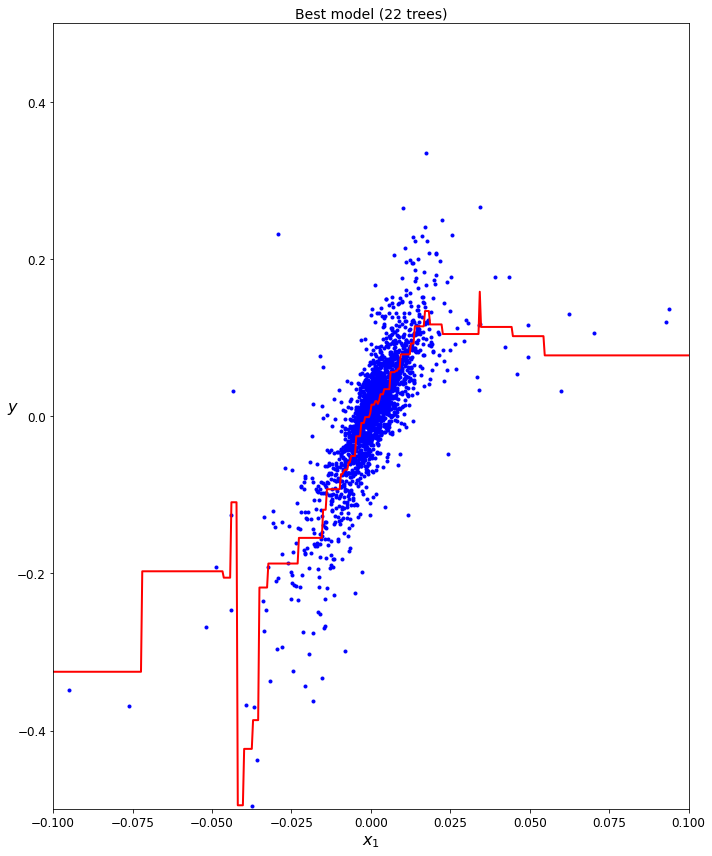

In [493]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.5, 0.5 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [494]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.04713745018535794


## Creation of Optimal Investment Portfolio

In [495]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [496]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

0.0005034996667769927 -0.0002170128691382292 0.0012240122026922146


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

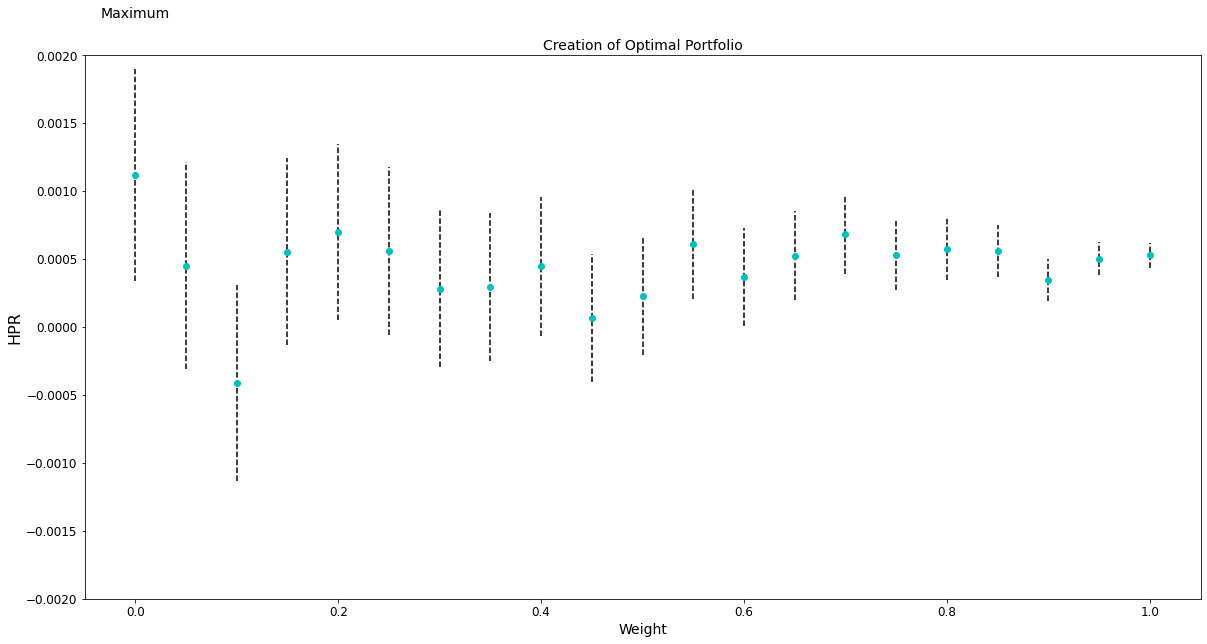

In [497]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.05,0.05)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.002, 0.002])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [498]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [499]:
print(boundary)

(-0.017493170651363417, 0.029156718353282658)


In [500]:
print(average_return)

0.005831773850959619


# Scenario 3 of Arbitrage
short SP500 and long SVXY

In [501]:
# calculate daily returns of shorting SP500 and longing UVXY
data1 = pd.merge(SP500.iloc[:, [4]], SVXY.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_SVXY'] =   np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) - 1
data1['r_SP500'] =  1 - np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]])   


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data1.head()

In [502]:
data1 = data1.dropna()
data1.head()

,P_SP500,P_SVXY,r_SVXY,r_SP500
Date,,,,
2011-10-05,1144.030029,22.695000,0.078147,-0.017866
2011-10-06,1164.969971,23.165001,0.020709,-0.018304
2011-10-07,1155.459961,23.344999,0.007770,0.008163
2011-10-10,1194.890015,24.299999,0.040908,-0.034125
2011-10-11,1195.540039,24.629999,0.013580,-0.000544


In [ ]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

In [ ]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

In [504]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30    0.009212
2020-05-01    0.028059
2020-05-04   -0.004250
2020-05-05   -0.009041
2020-05-06    0.006979
Name: r_SP500, dtype: float64

In [505]:
X = X.values.reshape((len(X),1))
X.shape

(2160, 1)

## Creation of Optimal Regressor 

In [506]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [507]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 1, 'n_estimators': 48}

In [508]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=48,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [509]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.04078836421441626 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 20}
0.040698398655152415 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 21}
0.040612305572729684 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 22}
0.04052720274534673 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 23}
0.040441301732600986 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 24}
0.04036106577902709 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 25}
0.04027741775144034 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 26}
0.04019944147387076 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 27}
0.04011897165861369 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 28}
0.040044493630546386 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 29}
0.039963070948995025 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 30}
0.03989164723104972 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 31}
0.03980923232929662 {'learning_rate

In [510]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.031180044661078595


In [511]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


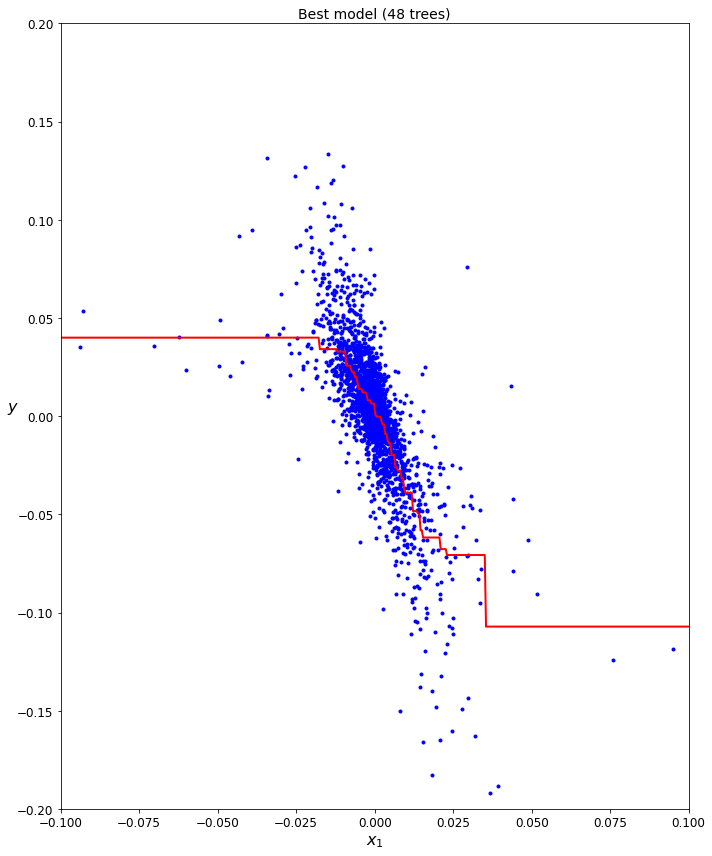

In [512]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [513]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.023420827633840766


## Creation of Optimal Hedge Fund

In [515]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [514]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

-0.001157762581169442 -0.0014568138372838412 -0.0008587113250550426


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

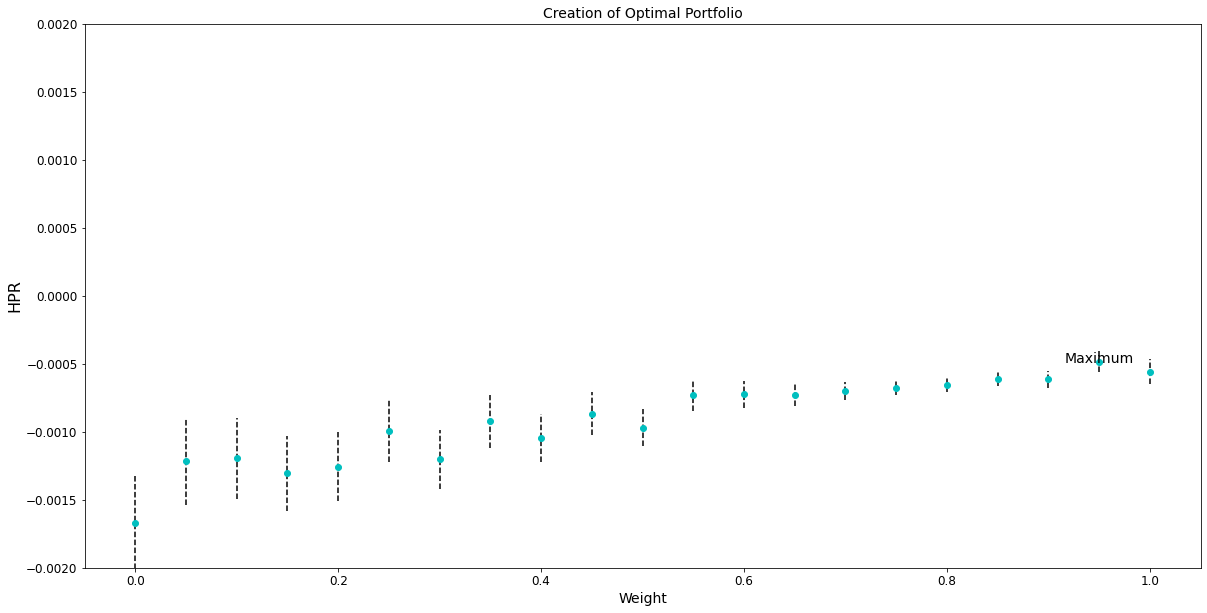

In [516]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.05,0.05)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.002, 0.002])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [517]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [518]:
print(boundary)

(-0.005297628036164315, 0.0008556590323531461)


In [519]:
print(average_return)

-0.0022209845019055844


# Scenario 4 of Arbitrage
short SP500 and short VIXY

In [520]:
# calculate daily returns of shorting SP500 and shorting UVXY
data1 = pd.merge(SP500.iloc[:, [4]], SVXY.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_SVXY'] =   1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] = 1 - np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]])   


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data1.head()

In [521]:
data1 = data1.dropna()
data1.head()

,P_SP500,P_VIXY,r_SVXY,r_SP500
Date,,,,
2011-10-05,1144.030029,10766.0,0.051036,-0.017866
2011-10-06,1164.969971,10586.0,0.016719,-0.018304
2011-10-07,1155.459961,10778.0,-0.018137,0.008163
2011-10-10,1194.890015,9996.0,0.072555,-0.034125
2011-10-11,1195.540039,9877.0,0.011905,-0.000544


In [ ]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

In [ ]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

In [522]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30    0.009212
2020-05-01    0.028059
2020-05-04   -0.004250
2020-05-05   -0.009041
2020-05-06    0.006979
Name: r_SP500, dtype: float64

In [523]:
X = X.values.reshape((len(X),1))
X.shape

(2160, 1)

## Creation of Optimal Regressor 

In [524]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [525]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 3, 'n_estimators': 20}

In [526]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=20,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [527]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.019652270233061354


In [528]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


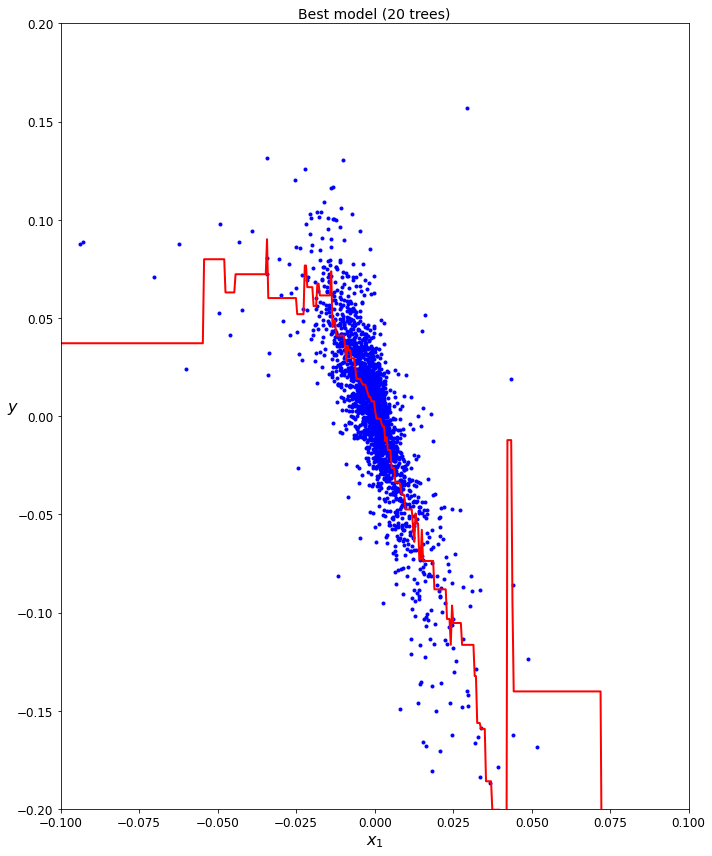

In [529]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [530]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.026291714427852976


## Creation of Optimal Hedge Fund

In [ ]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [531]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

-0.00024820756214308205 -0.0006250516743334486 0.00012863655004728458


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

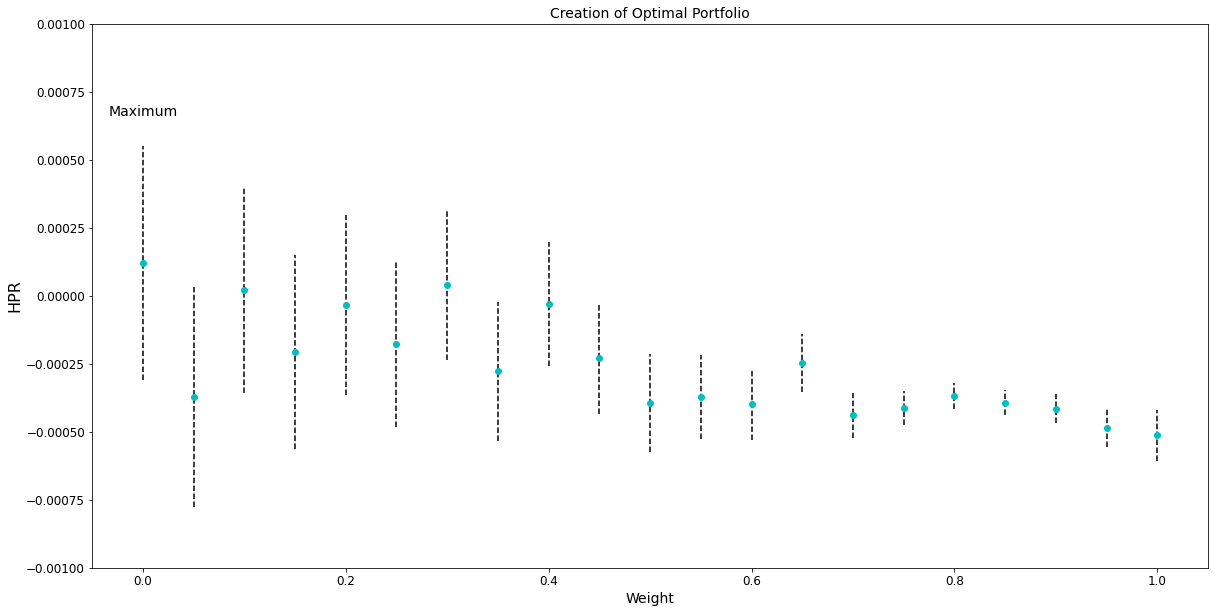

In [532]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.05,0.05)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.001, 0.001])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [533]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [534]:
print(boundary)

(-0.011941366478985688, 0.019193990467055826)


In [535]:
print(average_return)

0.003626311994035068


# Scenario 5 of Arbitrage
short SP500 and short VIXM

In [536]:
# calculate daily returns of shorting SP500 and shorting VIXM
data1 = pd.merge(SP500.iloc[:, [4]], VIXM.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_VIXM'] =   1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] = 1 - np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]])   


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [ ]:
data1.head()

In [537]:
data1 = data1.dropna()
data1.head()

,P_SP500,P_VIXM,r_VIXM,r_SP500
Date,,,,
2011-10-05,1144.030029,352.399994,0.018822,-0.017866
2011-10-06,1164.969971,350.399994,0.005675,-0.018304
2011-10-07,1155.459961,355.559998,-0.014726,0.008163
2011-10-10,1194.890015,339.559998,0.044999,-0.034125
2011-10-11,1195.540039,337.760010,0.005301,-0.000544


In [ ]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

In [ ]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

In [538]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30    0.009212
2020-05-01    0.028059
2020-05-04   -0.004250
2020-05-05   -0.009041
2020-05-06    0.006979
Name: r_SP500, dtype: float64

In [539]:
X = X.values.reshape((len(X),1))
X.shape

(2160, 1)

## Creation of Optimal Regressor 

In [540]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [541]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 2, 'n_estimators': 21}

In [542]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=21,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

In [543]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.010727475606555792


In [544]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


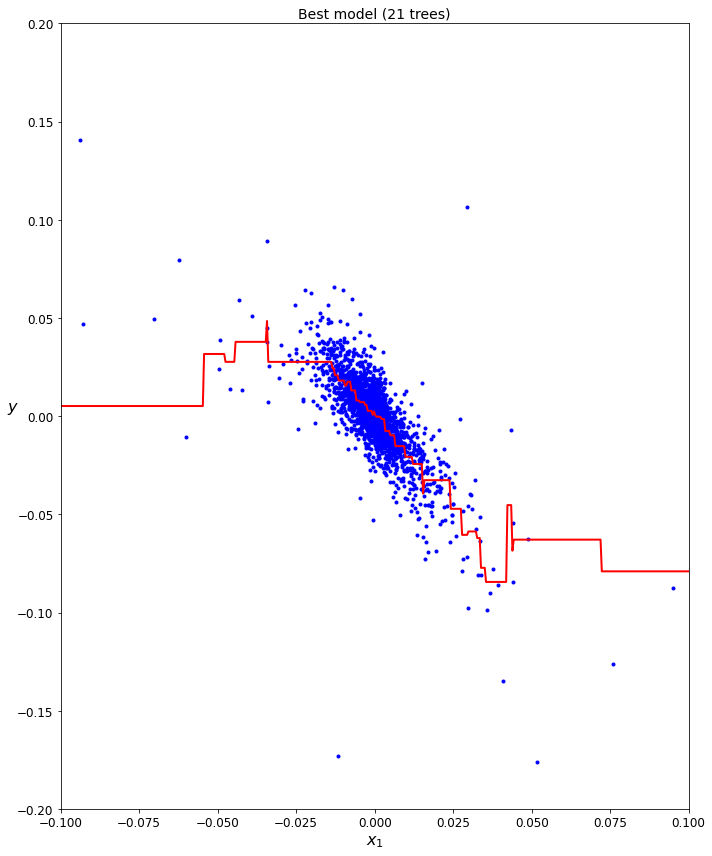

In [545]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [546]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.017889556383864812


## Creation of Optimal Hedge Fund

In [ ]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [547]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

0.00024151226049836207 4.855920717227157e-05 0.00043446531382445257


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

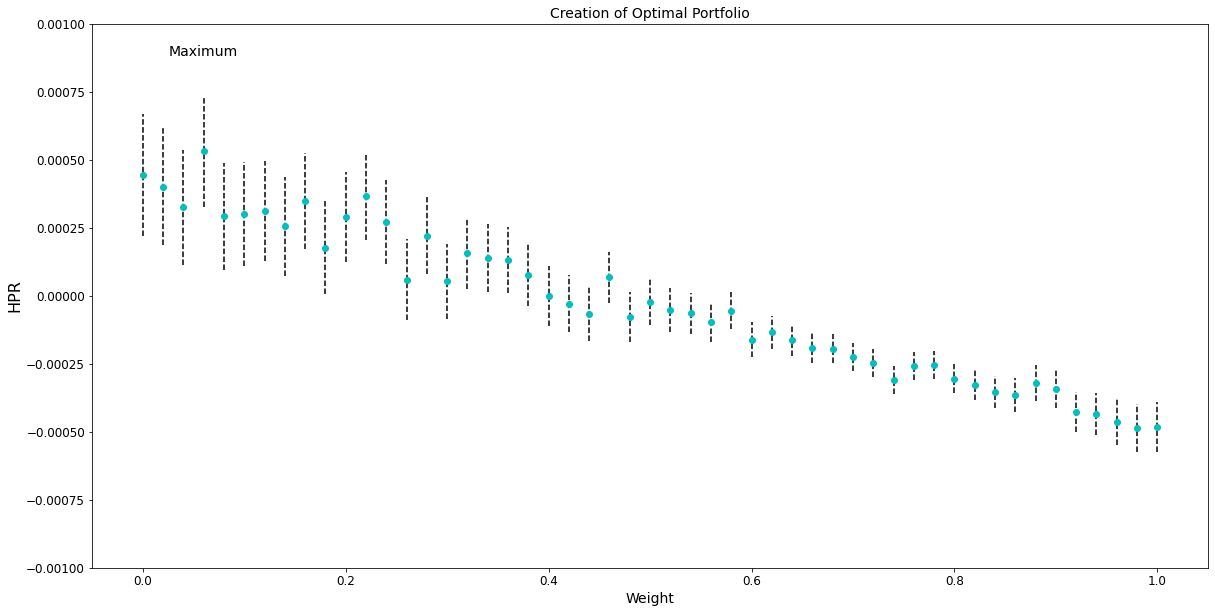

In [548]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.02,0.02)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.001, 0.001])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [549]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [552]:
print(boundary)

(-0.007111962463415254, 0.007028326595293756)


In [553]:
print(average_return)

-4.1817934060749675e-05


# Scenario 6 of Arbitrage
short SP500 and short VXX

In [554]:
# calculate daily returns of shorting SP500 and shorting VXX
data1 = pd.merge(SP500.iloc[:, [4]], VXX.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_VXX'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] =  1 - np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]])   


In [555]:
data1.head()

,Adj Close_x,Adj Close_y,r_VXX,r_SP500
Date,,,,
2018-01-25,270.068909,27.660000,NaN,NaN
2018-01-26,273.195648,27.660000,0.000000,-0.011578
2018-01-29,271.384430,29.580000,-0.069414,0.006630
2018-01-30,268.600830,30.549999,-0.032792,0.010257
2018-01-31,268.734192,30.650000,-0.003273,-0.000497


In [556]:
data1 = data1.dropna()
data1.head()

,Adj Close_x,Adj Close_y,r_VXX,r_SP500
Date,,,,
2018-01-26,273.195648,27.660000,0.000000,-0.011578
2018-01-29,271.384430,29.580000,-0.069414,0.006630
2018-01-30,268.600830,30.549999,-0.032792,0.010257
2018-01-31,268.734192,30.650000,-0.003273,-0.000497
2018-02-01,268.429230,29.107000,0.050343,0.001135


In [557]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_VXX,r_SP500,weekday
Date,,,,,
2020-07-27,323.220001,29.340000,0.027511,-0.007292,1
2020-07-28,321.170013,29.170000,0.005794,0.006342,2
2020-07-29,325.119995,28.570000,0.020569,-0.012299,3
2020-07-30,323.959991,29.200001,-0.022051,0.003568,4
2020-07-31,326.519989,28.520000,0.023288,-0.007902,5


In [558]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-26,300.049988,37.500000
2020-07-10,317.589996,32.150002
2020-07-17,321.720001,30.620001
2020-07-24,320.880005,30.170000
2020-07-31,326.519989,28.520000


In [559]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30    0.009311
2020-05-01    0.026473
2020-05-04   -0.002758
2020-05-05   -0.009239
2020-05-06    0.006779
Name: r_SP500, dtype: float64

In [560]:
X = X.values.reshape((len(X),1))
X.shape

(573, 1)

## Creation of Optimal Regressor 

In [561]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [562]:
grid_search.best_params_

{'learning_rate': 0.3, 'max_depth': 1, 'n_estimators': 22}

In [563]:
grid_search.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.3, loss='ls', max_depth=1,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=22,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [564]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.047057781853177 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 20}
0.04687888077304457 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 21}
0.04669186682788954 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 22}
0.04654814537430966 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 23}
0.04636591202151161 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 24}
0.046219386845062514 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 25}
0.046044179745825656 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 26}
0.04587685128819699 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 27}
0.04570065105318839 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 28}
0.04555701919965314 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 29}
0.04538462272088999 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 30}
0.045252542774230686 {'learning_rate': 0.01, 'max_depth': 1, 'n_estimators': 31}
0.04507908215390435 {'learning_rate': 0

In [565]:
y_pred_train = grid_search.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.02178324206003899


In [566]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


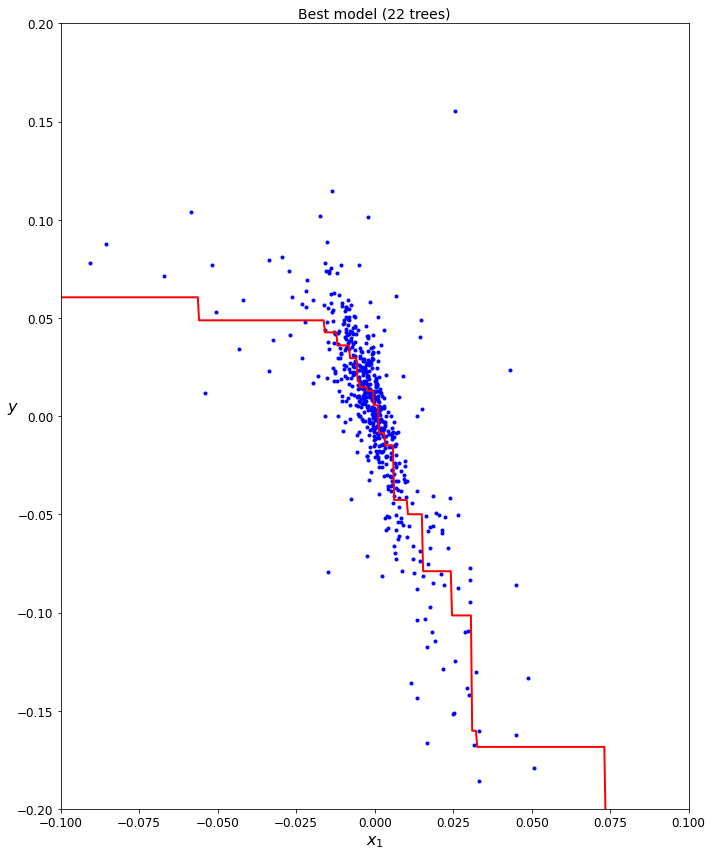

In [567]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search.best_params_['n_estimators']

plot_predictions([grid_search], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [568]:
y_pred = grid_search.predict(X_val)
test_error = mean_squared_error(y_val, y_pred, squared=False)
print(test_error)

0.040507062446666145


## Creation of Optimal Hedge Fund

In [569]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR(X, y, test_error, model, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      y  m x 1
      test error 1 x 1
      optimal model
      weight of SP500 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 
    error_std = test_error
    y_pred_sim = model.predict(X_sim) + error_std * np.random.randn(period,1) # m x 1
    holding_period_return = np.mean( weight * X_sim + (1 - weight) * y_pred_sim )    # m x 1 → 1 x 1
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [570]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, weight=0.1)
print(average_HPR, bound_left, bound_right)

-0.006696152106359666 -0.007194222592118477 -0.006198081620600856


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

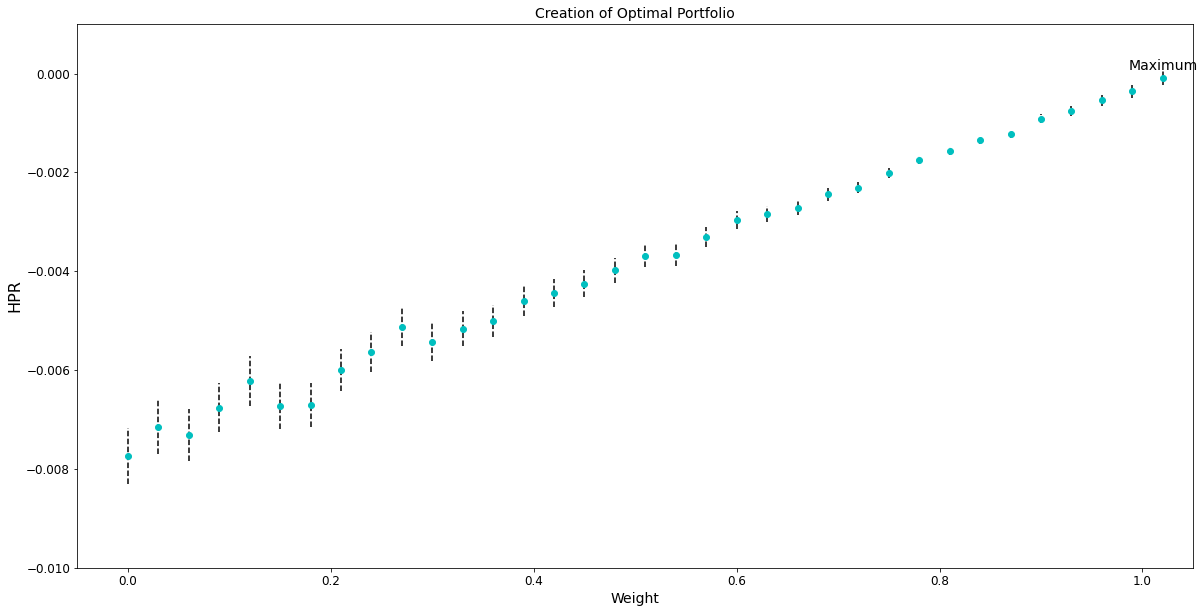

In [576]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.03,0.03)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR(X, y, test_error, grid_search, w)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.01, 0.001])
plt.xlabel("Weight")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [577]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [578]:
print(boundary)

(-0.00647522279657332, 0.001268824114708668)


In [579]:
print(average_return)

-0.0026031993409323263


# Advanced portfolio ---------------

# Scenario 7 of Arbitrage
long SPXU and short VIXY   

Note: Suppose you long SPY for calculation purpose

## Creation of Optimal Regressor 1

In [619]:
# calculate daily returns of longing SP500 and shorting VIXY
data1 = pd.merge(SP500.iloc[:, [4]], VIXY.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_VIXY'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] =  np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]]) - 1 


In [620]:
data1.head()

,Adj Close_x,Adj Close_y,r_VIXY,r_SP500
Date,,,,
2011-01-04,104.923828,7923.0,NaN,NaN
2011-01-05,105.469177,7755.0,0.021204,0.005198
2011-01-06,105.262604,7788.0,-0.004255,-0.001959
2011-01-07,105.056030,7804.0,-0.002054,-0.001962
2011-01-10,104.923828,7788.0,0.002050,-0.001258


In [621]:
data1 = data1.dropna()
data1.head()

,Adj Close_x,Adj Close_y,r_VIXY,r_SP500
Date,,,,
2011-01-05,105.469177,7755.0,0.021204,0.005198
2011-01-06,105.262604,7788.0,-0.004255,-0.001959
2011-01-07,105.056030,7804.0,-0.002054,-0.001962
2011-01-10,104.923828,7788.0,0.002050,-0.001258
2011-01-11,105.295677,7573.0,0.027607,0.003544


In [622]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_VIXY,r_SP500,weekday
Date,,,,,
2020-07-27,323.220001,24.010000,0.027935,0.007292,1
2020-07-28,321.170013,23.870001,0.005831,-0.006342,2
2020-07-29,325.119995,23.379999,0.020528,0.012299,3
2020-07-30,323.959991,23.930000,-0.023524,-0.003568,4
2020-07-31,326.519989,23.440001,0.020476,0.007902,5


In [623]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-26,300.049988,30.770000
2020-07-10,317.589996,26.410000
2020-07-17,321.720001,25.080000
2020-07-24,320.880005,24.700001
2020-07-31,326.519989,23.440001


In [624]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30   -0.009311
2020-05-01   -0.026473
2020-05-04    0.002758
2020-05-05    0.009239
2020-05-06   -0.006779
Name: r_SP500, dtype: float64

In [625]:
X = X.values.reshape((len(X),1))
X.shape

(2349, 1)

In [626]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search1 = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search1.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [627]:
grid_search1.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 41}

In [628]:
grid_search1.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=41,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
'''
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
'''

In [629]:
y_pred_train = grid_search1.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.022182664962774306


In [630]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


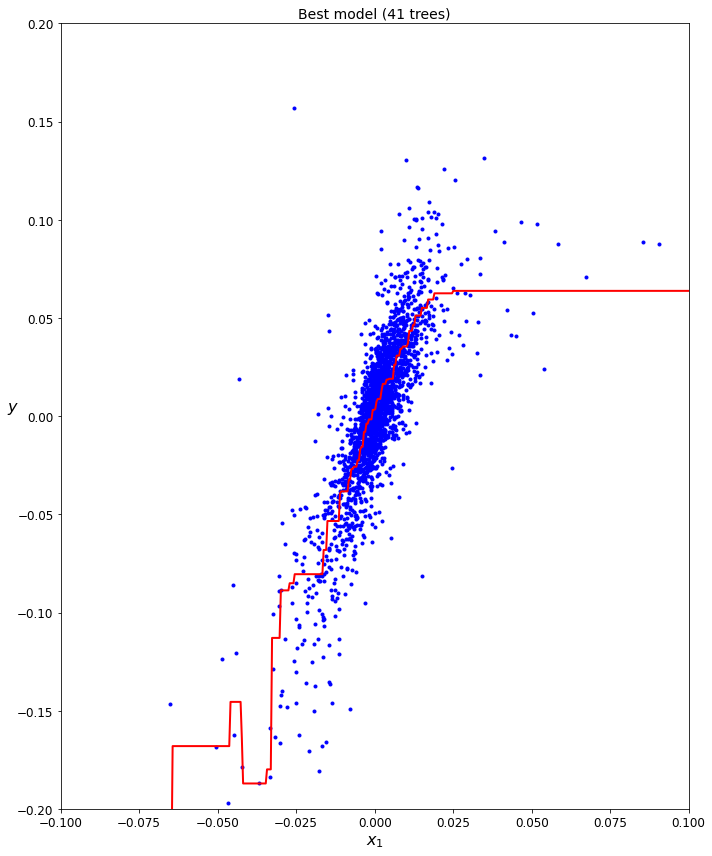

In [631]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search1.best_params_['n_estimators']

plot_predictions([grid_search1], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [632]:
y_pred = grid_search1.predict(X_val)
test_error1 = mean_squared_error(y_val, y_pred, squared=False)
print(test_error1)

0.022152706293001534


## Creation of Optimal Regressor 2

In [633]:
# calculate daily returns of longing SP500 and longing SPXU
data1 = pd.merge(SP500.iloc[:, [4]], SPXU.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_SPXU'] =  np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) - 1 
data1['r_SP500'] =  np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]]) - 1    

In [634]:
data1.head()

,Adj Close_x,Adj Close_y,r_SPXU,r_SP500
Date,,,,
2010-08-02,92.192802,2271.646484,NaN,NaN
2010-08-03,91.751305,2301.007813,0.012925,-0.004789
2010-08-04,92.364510,2255.420410,-0.019812,0.006683
2010-08-05,92.266380,2263.919922,0.003768,-0.001062
2010-08-06,91.890297,2289.417725,0.011263,-0.004076


In [635]:
data1 = data1.dropna()
data1.head()

,Adj Close_x,Adj Close_y,r_SPXU,r_SP500
Date,,,,
2010-08-03,91.751305,2301.007813,0.012925,-0.004789
2010-08-04,92.364510,2255.420410,-0.019812,0.006683
2010-08-05,92.266380,2263.919922,0.003768,-0.001062
2010-08-06,91.890297,2289.417725,0.011263,-0.004076
2010-08-09,92.380859,2253.102295,-0.015862,0.005339


In [ ]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_VXX,r_SP500,weekday
Date,,,,,
2020-07-27,323.220001,29.340000,0.027511,-0.007292,1
2020-07-28,321.170013,29.170000,0.005794,0.006342,2
2020-07-29,325.119995,28.570000,0.020569,-0.012299,3
2020-07-30,323.959991,29.200001,-0.022051,0.003568,4
2020-07-31,326.519989,28.520000,0.023288,-0.007902,5


In [ ]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-26,300.049988,37.500000
2020-07-10,317.589996,32.150002
2020-07-17,321.720001,30.620001
2020-07-24,320.880005,30.170000
2020-07-31,326.519989,28.520000


In [636]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30   -0.009311
2020-05-01   -0.026473
2020-05-04    0.002758
2020-05-05    0.009239
2020-05-06   -0.006779
Name: r_SP500, dtype: float64

In [637]:
X = X.values.reshape((len(X),1))
X.shape

(2457, 1)

In [638]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search2 = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search2.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [639]:
grid_search2.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 42}

In [640]:
grid_search2.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=42,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [ ]:
'''
cvres = grid_search2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
'''

In [641]:
y_pred_train = grid_search2.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.0019274894740247176


In [642]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


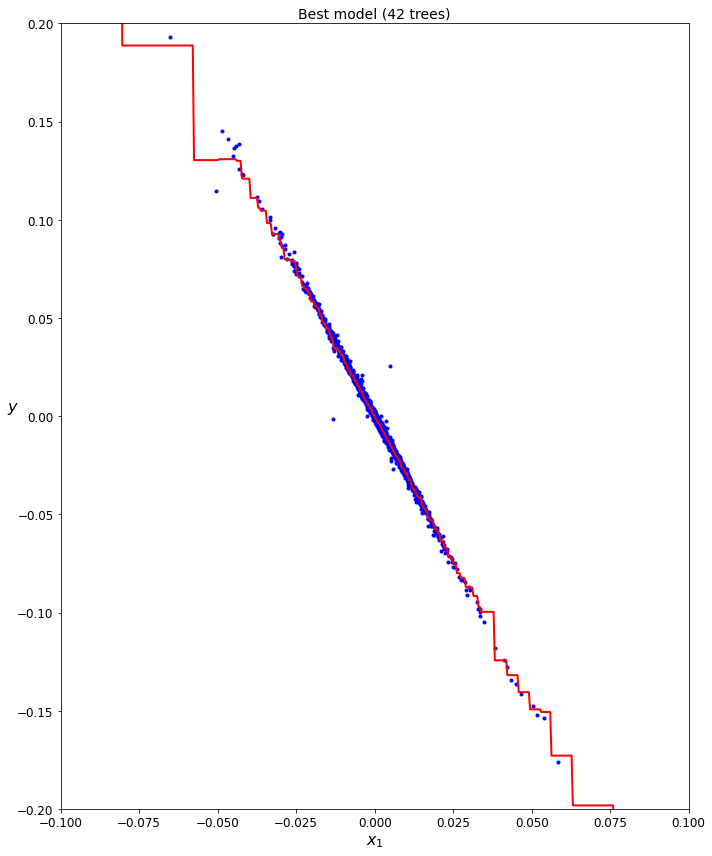

In [643]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search2.best_params_['n_estimators']

plot_predictions([grid_search2], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [645]:
y_pred = grid_search2.predict(X_val)
test_error2 = mean_squared_error(y_val, y_pred, squared=False)
print(test_error2)

0.0025017902350740746


## Creation of Optimal Hedge Fund

In [609]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR_advanced(X, test_error1, test_error2, model1, model2, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      2 test errors
      2 optimal models
      weight of model1 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 

    y_pred_sim1 = model1.predict(X_sim) + test_error1 * np.random.randn(period,1) # m x 1
    y_pred_sim2 = model2.predict(X_sim) + test_error2 * np.random.randn(period,1) # m x 1

    holding_period_return = np.mean( weight * y_pred_sim1 + (1 - weight) * y_pred_sim2 )    # m x 1 → 1 x 1
    
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [646]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR_advanced(X, test_error1, test_error2, grid_search1, grid_search2, 0.1)
print(average_HPR, bound_left, bound_right)

-0.0011551012553423893 -0.001371181182946282 -0.0009390213277384967


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

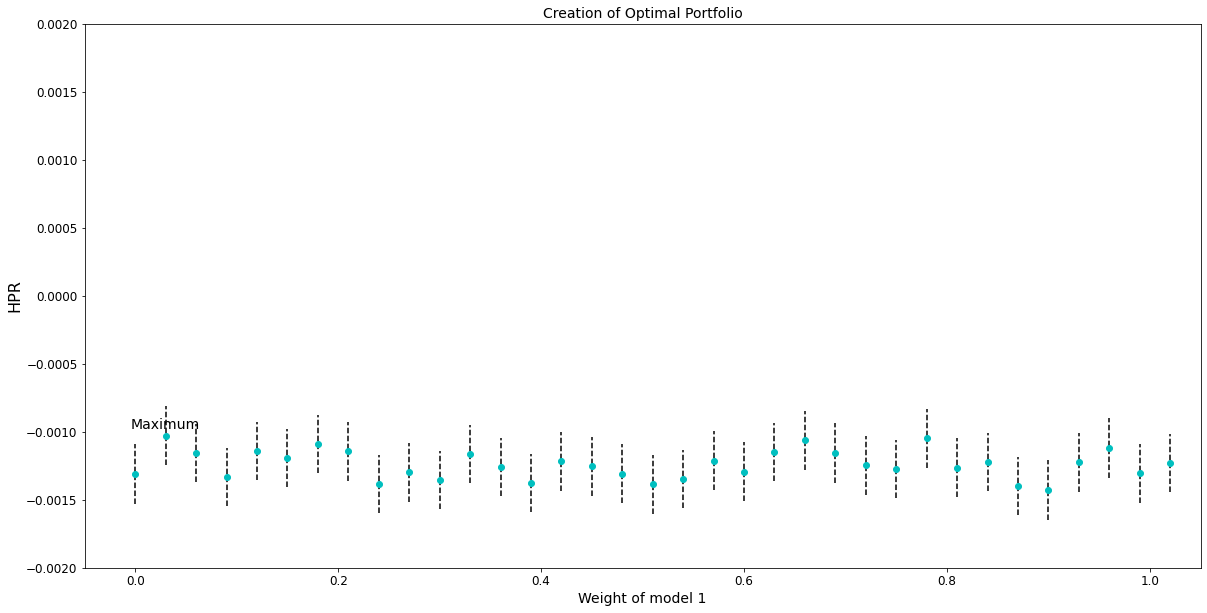

In [613]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.03,0.03)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR_advanced(X, test_error1, test_error2, grid_search1, grid_search2, 0.1)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.002, 0.002])
plt.xlabel("Weight of model 1")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [ ]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [ ]:
print(boundary)

(-0.00647522279657332, 0.001268824114708668)


In [ ]:
print(average_return)

-0.0026031993409323263


# Scenario 8 of Arbitrage
short SPUU and short VIXY   

Note: Suppose you long SPY for calculation purpose

## Creation of Optimal Regressor 1

In [655]:
# calculate daily returns of longing SP500 and shorting VIXY
data1 = pd.merge(SP500.iloc[:, [4]], VIXY.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_VIXY'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]]) 
data1['r_SP500'] =  np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]]) - 1 


In [656]:
data1.head()

,Adj Close_x,Adj Close_y,r_VIXY,r_SP500
Date,,,,
2011-01-04,104.923828,7923.0,NaN,NaN
2011-01-05,105.469177,7755.0,0.021204,0.005198
2011-01-06,105.262604,7788.0,-0.004255,-0.001959
2011-01-07,105.056030,7804.0,-0.002054,-0.001962
2011-01-10,104.923828,7788.0,0.002050,-0.001258


In [657]:
data1 = data1.dropna()
data1.head()

,Adj Close_x,Adj Close_y,r_VIXY,r_SP500
Date,,,,
2011-01-05,105.469177,7755.0,0.021204,0.005198
2011-01-06,105.262604,7788.0,-0.004255,-0.001959
2011-01-07,105.056030,7804.0,-0.002054,-0.001962
2011-01-10,104.923828,7788.0,0.002050,-0.001258
2011-01-11,105.295677,7573.0,0.027607,0.003544


In [658]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_VIXY,r_SP500,weekday
Date,,,,,
2020-07-27,323.220001,24.010000,0.027935,0.007292,1
2020-07-28,321.170013,23.870001,0.005831,-0.006342,2
2020-07-29,325.119995,23.379999,0.020528,0.012299,3
2020-07-30,323.959991,23.930000,-0.023524,-0.003568,4
2020-07-31,326.519989,23.440001,0.020476,0.007902,5


In [659]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-26,300.049988,30.770000
2020-07-10,317.589996,26.410000
2020-07-17,321.720001,25.080000
2020-07-24,320.880005,24.700001
2020-07-31,326.519989,23.440001


In [660]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30   -0.009311
2020-05-01   -0.026473
2020-05-04    0.002758
2020-05-05    0.009239
2020-05-06   -0.006779
Name: r_SP500, dtype: float64

In [661]:
X = X.values.reshape((len(X),1))
X.shape

(2349, 1)

In [662]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search1 = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search1.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [663]:
grid_search1.best_params_

{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 41}

In [664]:
grid_search1.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=2,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=41,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [665]:
'''
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
'''

'\ncvres = grid_search.cv_results_\nfor mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    print(np.sqrt(-mean_score), params)\n'

In [666]:
y_pred_train = grid_search1.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.022182664962774306


In [667]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


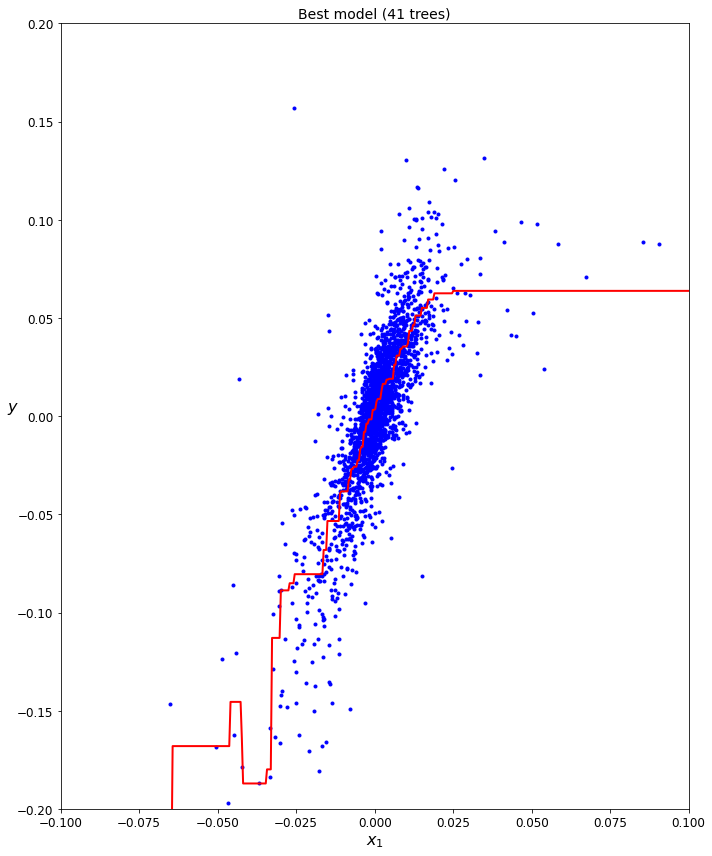

In [668]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search1.best_params_['n_estimators']

plot_predictions([grid_search1], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [669]:
y_pred = grid_search1.predict(X_val)
test_error1 = mean_squared_error(y_val, y_pred, squared=False)
print(test_error1)

0.022152706293001534


## Creation of Optimal Regressor 2

In [670]:
# calculate daily returns of longing SP500 and shorting SPUU
data1 = pd.merge(SP500.iloc[:, [4]], SPUU.iloc[:, [4]], left_on='Date', right_on='Date',how='inner')
data1['r_SPUU'] =  1 - np.divide(data1.iloc[1:,[1]],data1.iloc[:-1,[1]])  
data1['r_SP500'] =  np.divide(data1.iloc[1:,[0]],data1.iloc[:-1,[0]]) - 1    

In [671]:
data1.head()

,Adj Close_x,Adj Close_y,r_SPUU,r_SP500
Date,,,,
2014-05-28,169.111237,24.013405,NaN,NaN
2014-05-29,169.986053,24.253782,-0.010010,0.005173
2014-05-30,170.259949,24.319883,-0.002725,0.001611
2014-06-02,170.454361,24.373966,-0.002224,0.001142
2014-06-03,170.366043,24.349930,0.000986,-0.000518


In [672]:
data1 = data1.dropna()
data1.head()

,Adj Close_x,Adj Close_y,r_SPUU,r_SP500
Date,,,,
2014-05-29,169.986053,24.253782,-0.010010,0.005173
2014-05-30,170.259949,24.319883,-0.002725,0.001611
2014-06-02,170.454361,24.373966,-0.002224,0.001142
2014-06-03,170.366043,24.349930,0.000986,-0.000518
2014-06-04,170.710648,24.458096,-0.004442,0.002023


In [673]:
# determine weekday
week = ["MON","TUE","WED","THU","FRI"]
data1["weekday"] = data1.index.dayofweek + 1
data1.tail()

,Adj Close_x,Adj Close_y,r_SPUU,r_SP500,weekday
Date,,,,,
2020-07-27,323.220001,60.160000,-0.015016,0.007292,1
2020-07-28,321.170013,59.419998,0.012301,-0.006342,2
2020-07-29,325.119995,60.810001,-0.023393,0.012299,3
2020-07-30,323.959991,60.470001,0.005591,-0.003568,4
2020-07-31,326.519989,61.250000,-0.012899,0.007902,5


In [674]:
# split data into five subsets according to weekday if you want to make more precise position adjustments on every trading day.
for i in range(1,6):
  locals()['data1_{0}'.format(i)] = data1[data1["weekday"]==i].iloc[:,[0,1]]
data1_5.tail()

,Adj Close_x,Adj Close_y
Date,,
2020-06-26,300.049988,52.080002
2020-07-10,317.589996,58.270000
2020-07-17,321.720001,59.720001
2020-07-24,320.880005,59.270000
2020-07-31,326.519989,61.250000


In [675]:
y, X = data1.iloc[:-60,2], data1.iloc[:-60,3]
y_portfolio_test, X_portfolio_test = data1.iloc[-60:,2], data1.iloc[-60:,3]
X.tail()

Date
2020-04-30   -0.009311
2020-05-01   -0.026473
2020-05-04    0.002758
2020-05-05    0.009239
2020-05-06   -0.006779
Name: r_SP500, dtype: float64

In [676]:
X = X.values.reshape((len(X),1))
X.shape

(1496, 1)

In [677]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
param_grid = [  {'n_estimators': np.arange(20, 50), 'max_depth': np.arange(1, 4), 'learning_rate': [0.01,0.03,0.1,0.3,1]} ]

gbrt = GradientBoostingRegressor(random_state=49)

grid_search2 = GridSearchCV(gbrt, param_grid, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid_search2.fit(X_train, y_train)


GridSearchCV(cv=3, error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_samples_split=2,
                                                 min_weight_fraction_leaf=0.0,
                                                 n_estimators=100,
                                                 n_iter_n...
                            

In [678]:
grid_search2.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 47}

In [679]:
grid_search2.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=47,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=49, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [680]:
'''
cvres = grid_search2.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)
'''

'\ncvres = grid_search2.cv_results_\nfor mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):\n    print(np.sqrt(-mean_score), params)\n'

In [681]:
y_pred_train = grid_search2.predict(X_train)
val_error = mean_squared_error(y_train, y_pred_train, squared=False)
print(val_error)

0.005201911170167472


In [682]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure Model Visualization


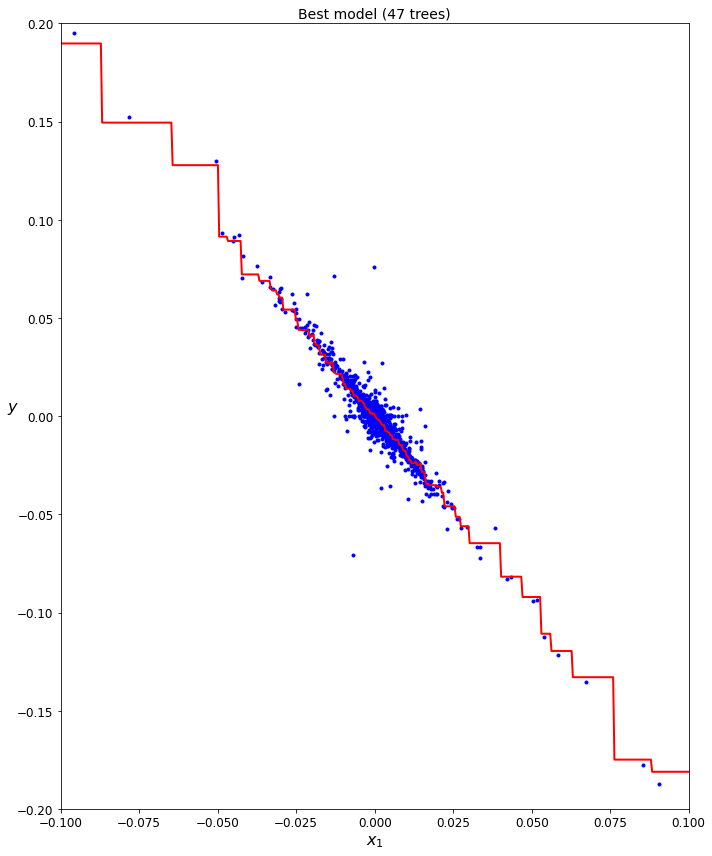

In [683]:
plt.figure(figsize=(10, 12))

bst_n_estimators = grid_search2.best_params_['n_estimators']

plot_predictions([grid_search2], X, y, axes=[-0.1, 0.1,-0.2, 0.2 ])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.xlabel("$x_1$", fontsize=16)

save_fig("Model Visualization")
plt.show()

In [684]:
y_pred = grid_search2.predict(X_val)
test_error2 = mean_squared_error(y_val, y_pred, squared=False)
print(test_error2)

0.005895333989192203


## Creation of Optimal Hedge Fund

In [685]:
# make a function to calculate expected return and standard deviation using Monte Carlo simulation
def HPR_advanced(X, test_error1, test_error2, model1, model2, weight, period=5, sim=10000, alpha=0.05):
  """
  input: X  m x 1
      2 test errors
      2 optimal models
      weight of model1 # 1 x 1
      sample size m in terms of holding period (default: 5 trading days)
      number of simulations (default: 10000)
      alpha (default: 0.05)
  output: tuple of 3 values: 
       expected HPR
       boundary of 95% confidence level   
  """
  import numpy as np
  from scipy.stats import norm
  from scipy.stats import t
  sim=int(sim)
  count = 0
  average_HPR = 0
  std_HPR = 0
  t_score = 0
  boundary = (0,0) 
  HPR = np.zeros((sim, 1)) # sim x 1 
  while count < sim:
    X_std = np.std(X)      # m x 1 → 1 x 1  
    X_mean = np.mean(X)     # m x 1 → 1 x 1 
    X_sim = X_mean + X_std * np.random.randn(period,1) # m x 1 

    y_pred_sim1 = model1.predict(X_sim) + test_error1 * np.random.randn(period,1) # m x 1
    y_pred_sim2 = model2.predict(X_sim) + test_error2 * np.random.randn(period,1) # m x 1

    holding_period_return = np.mean( weight * y_pred_sim1 + (1 - weight) * y_pred_sim2 )    # m x 1 → 1 x 1
    
    HPR[count,0] = holding_period_return
    count += 1
  average_HPR = np.mean(HPR)
  std_HPR = np.std(HPR)
  t_score = t.isf(alpha / 2, df = (sim - 1) )
  boundary = (average_HPR - t_score * std_HPR / np.sqrt(sim)  , average_HPR + t_score * std_HPR / np.sqrt(sim) )
  return (average_HPR, boundary[0], boundary[1])   
  # tc o(sim)
  # sc o(sim)






In [686]:
# try weight = 10%
average_HPR, bound_left, bound_right = HPR_advanced(X, test_error1, test_error2, grid_search1, grid_search2, 0.1)
print(average_HPR, bound_left, bound_right)

-0.0008471694366251135 -0.0009882816334022537 -0.0007060572398479732


Text(0.5, 1.0, 'Creation of Optimal Portfolio')

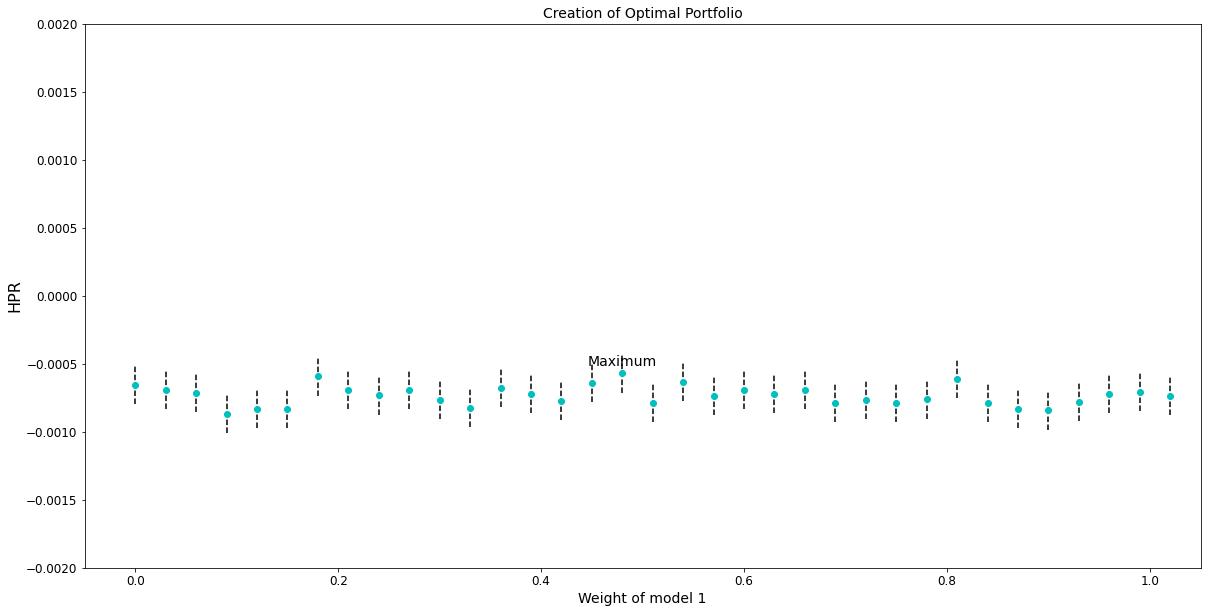

In [687]:
# draw a big graph to find optimal portfolio
plt.figure(figsize=(20, 10))
weight = np.arange(0,1.03,0.03)
max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = -10, -10, 10
for w in weight:
  average_HPR, bound_left, bound_right = HPR_advanced(X, test_error1, test_error2, grid_search1, grid_search2, 0.1)
  plt.plot([w, w], [bound_left, bound_right], "k--")
  plt.plot(w, average_HPR, "co")
  if average_HPR > max_HPR:
    w_best, max_HPR, bound_left_for_max_HPR, bound_right_for_max_HPR = w, average_HPR, bound_left, bound_right 
     
plt.text(w_best, bound_right_for_max_HPR*1.2, "Maximum", ha="center", fontsize=14) 
plt.axis([-0.05, 1.05, -0.002, 0.002])
plt.xlabel("Weight of model 1")
plt.ylabel("HPR", fontsize=16)
plt.title("Creation of Optimal Portfolio", fontsize=14)

## Portfolio Testing

In [688]:
from scipy.stats import t
test_return = y_portfolio_test * (1-w_best) + X_portfolio_test * w_best
average_return = np.mean(test_return)
std_return = np.std(test_return)
m = y_portfolio_test.shape[0]
alpha = 0.05
t_score = t.isf(alpha / 2, df = (m - 1) )
boundary = (average_return - t_score * std_return / np.sqrt(m)  , average_return + t_score * std_return / np.sqrt(m) )

In [689]:
print(boundary)

(-0.003372009614429276, 0.0007025250662361972)


In [690]:
print(average_return)

-0.0013347422740965394
